In [10]:

!pip install minisom
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Allow uploads
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart (1).csv


In [18]:
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('heart.csv')

# Split into train and test sets (820 train, 205 test)
train_data = df.iloc[:820, :].copy()
test_data = df.iloc[820:, :].copy()

# Save index for identification
train_data['index'] = train_data.index
test_data['index'] = test_data.index


# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data.drop(columns=['index']))
X_test = scaler.transform(test_data.drop(columns=['index']))




In [19]:
# Initialize SOM
som = MiniSom(x=10, y=10, input_len=X_train.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_train)

# Train SOM
som.train_random(data=X_train, num_iteration=1000)

In [20]:
# Map each sample to its BMU (Best Matching Unit)
mapped_coords = np.array([som.winner(x) for x in X_train])
train_data['bmu_x'] = mapped_coords[:, 0]
train_data['bmu_y'] = mapped_coords[:, 1]

In [21]:
# Features associated with heart attack risk
risk_factors = ['chol', 'trestbps', 'thalach', 'oldpeak', 'exang', 'cp']

# Group by neuron (BMU) coordinates
cluster_profiles = train_data.groupby(['bmu_x', 'bmu_y'])[risk_factors].mean().reset_index()

# Add patient count per cluster
cluster_profiles['count'] = train_data.groupby(['bmu_x', 'bmu_y']).size().values

# Compute risk score based on feature weighting
def compute_risk_score(row):
    return (
        row['chol'] * 0.25 +
        row['trestbps'] * 0.25 +
        (1 - row['thalach']) * 0.2 +
        row['oldpeak'] * 0.15 +
        row['exang'] * 0.1 +
        (1 - row['cp']) * 0.05
    )

cluster_profiles['risk_score'] = cluster_profiles.apply(compute_risk_score, axis=1)

# Show top 10 riskiest clusters
high_risk_clusters = cluster_profiles.sort_values(by='risk_score', ascending=False)
high_risk_clusters.head(10)

,bmu_x,bmu_y,chol,trestbps,thalach,oldpeak,exang,cp,count,risk_score
8,0,9,376.875000,131.125000,150.375000,0.787500,0.0,2.000000,8,97.193125
54,7,4,284.666667,167.333333,138.333333,3.266667,1.0,0.000000,12,86.173333
47,6,3,282.727273,170.181818,140.909091,1.309091,1.0,0.000000,11,85.591818
45,6,1,303.000000,130.000000,122.000000,2.000000,0.0,0.000000,3,84.400000
33,3,9,288.937500,127.781250,119.250000,2.206250,1.0,0.000000,32,81.010625
41,5,0,318.000000,114.000000,140.000000,4.400000,0.0,0.000000,3,80.910000
60,8,0,308.875000,122.750000,140.375000,0.875000,0.0,0.000000,8,80.212500
53,7,3,295.181818,139.818182,149.454545,0.745455,1.0,0.000000,11,79.320909
72,9,9,257.571429,153.571429,125.428571,4.228571,1.0,0.000000,7,78.684286
70,9,6,292.388889,130.666667,136.888889,0.516667,0.0,1.611111,18,78.633056


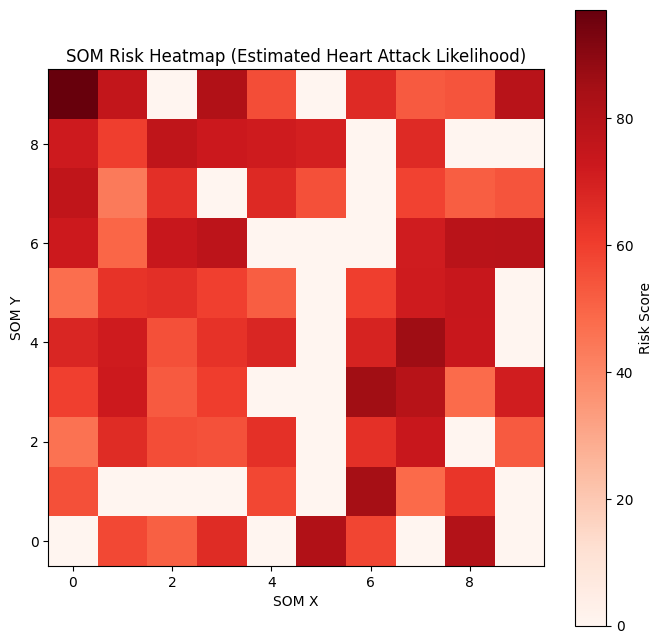

In [22]:
# Create grid for visualization
risk_grid = np.zeros((10, 10))

for _, row in cluster_profiles.iterrows():
    x, y = int(row['bmu_x']), int(row['bmu_y'])
    risk_grid[x, y] = row['risk_score']

# Plot heatmap
plt.figure(figsize=(8, 8))
plt.imshow(risk_grid.T, cmap='Reds', origin='lower')
plt.colorbar(label='Risk Score')
plt.title('SOM Risk Heatmap (Estimated Heart Attack Likelihood)')
plt.xlabel('SOM X')
plt.ylabel('SOM Y')
plt.grid(False)
plt.show()

In [16]:
# Choose top 5 risky clusters
top_clusters = high_risk_clusters.head(5)[['bmu_x', 'bmu_y']].values.tolist()

# Find patients that mapped to those neurons
high_risk_patients = train_data[train_data[['bmu_x', 'bmu_y']].apply(tuple, axis=1).isin([tuple(x) for x in top_clusters])]
high_risk_patients[['index'] + risk_factors]

,index,chol,trestbps,thalach,oldpeak,exang,cp
4,4,294,138,106,1.9,0,0
32,32,131,130,115,1.2,1,0
38,38,263,128,105,0.2,1,0
97,97,282,123,95,2.0,1,0
140,140,274,152,88,1.2,1,0
158,158,564,115,160,1.6,0,2
192,192,564,115,160,1.6,0,2
218,218,311,140,120,1.8,1,0
247,247,311,140,120,1.8,1,0
252,252,353,132,132,1.2,1,0


In [23]:
!pip install minisom
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


from google.colab import files
uploaded = files.upload()


df = pd.read_csv('heart.csv')


train_data = df.iloc[:820, :].copy()
test_data = df.iloc[820:, :].copy()


test_data['index'] = test_data.index


scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data.drop(columns=['index']))


som = MiniSom(x=10, y=10, input_len=X_train.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_train)
som.train_random(data=X_train, num_iteration=1000)


mapped_coords_test = np.array([som.winner(x) for x in X_test])
test_data['bmu_x'] = mapped_coords_test[:, 0]
test_data['bmu_y'] = mapped_coords_test[:, 1]


risk_factors = ['chol', 'trestbps', 'thalach', 'oldpeak', 'exang', 'cp']


cluster_profiles_test = test_data.groupby(['bmu_x', 'bmu_y'])[risk_factors].mean().reset_index()


cluster_profiles_test['count'] = test_data.groupby(['bmu_x', 'bmu_y']).size().values


def compute_risk_score(row):
    return (
        row['chol'] * 0.25 +
        row['trestbps'] * 0.25 +
        (1 - row['thalach']) * 0.2 +
        row['oldpeak'] * 0.15 +
        row['exang'] * 0.1 +
        (1 - row['cp']) * 0.05
    )

cluster_profiles_test['risk_score'] = cluster_profiles_test.apply(compute_risk_score, axis=1)


high_risk_clusters_test = cluster_profiles_test.sort_values(by='risk_score', ascending=False)
high_risk_clusters_test.head(10)

Saving heart.csv to heart (3).csv


,bmu_x,bmu_y,chol,trestbps,thalach,oldpeak,exang,cp,count,risk_score
45,7,1,297.500000,151.000000,127.500000,0.750000,1.0,0.00,2,87.087500
48,7,8,322.500000,136.000000,151.000000,1.050000,1.0,0.00,2,84.932500
46,7,4,285.000000,155.000000,139.250000,0.000000,0.0,2.75,4,82.262500
22,3,4,318.000000,114.000000,140.000000,4.400000,0.0,0.00,1,80.910000
34,5,6,300.250000,145.000000,157.750000,3.450000,0.0,0.00,4,80.530000
36,6,1,274.500000,121.500000,97.000000,1.900000,1.0,0.00,2,80.235000
3,0,7,300.200000,136.200000,147.400000,0.360000,0.0,2.00,5,79.824000
42,6,8,269.000000,153.333333,133.333333,0.133333,1.0,0.00,3,79.286667
32,5,3,261.666667,172.666667,153.000000,1.666667,0.0,3.00,3,78.333333
37,6,2,263.000000,128.000000,105.000000,0.200000,1.0,0.00,1,77.130000


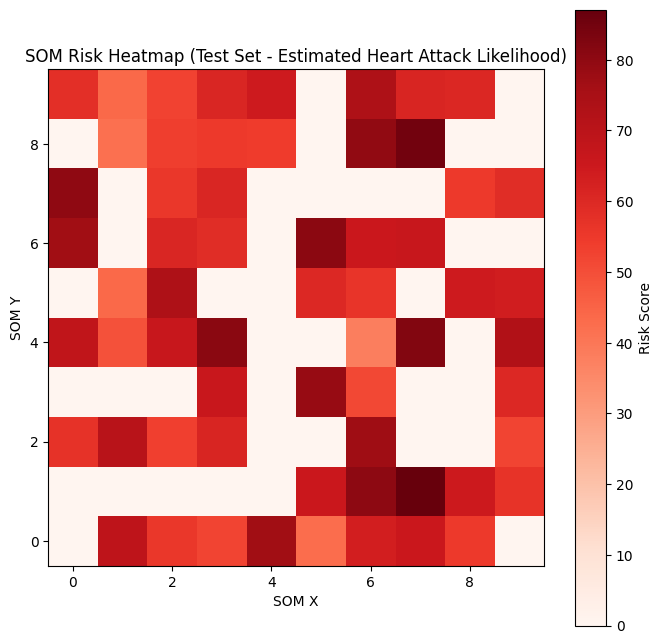

,index,chol,trestbps,thalach,oldpeak,exang,cp
821,821,268,140,160,3.6,0,0
843,843,273,160,125,0.0,0,3
864,864,273,160,125,0.0,0,3
871,871,321,140,182,0.0,0,2
874,874,273,160,125,0.0,0,3
888,888,258,150,157,2.6,0,0
889,889,407,150,154,4.0,0,0
902,902,268,140,160,3.6,0,0
950,950,286,160,108,1.5,1,0
953,953,236,138,152,0.2,1,0


In [24]:
# Create grid for visualization
risk_grid_test = np.zeros((10, 10))

for _, row in cluster_profiles_test.iterrows():
    x, y = int(row['bmu_x']), int(row['bmu_y'])
    risk_grid_test[x, y] = row['risk_score']

# Plot heatmap
plt.figure(figsize=(8, 8))
plt.imshow(risk_grid_test.T, cmap='Reds', origin='lower')
plt.colorbar(label='Risk Score')
plt.title('SOM Risk Heatmap (Test Set - Estimated Heart Attack Likelihood)')
plt.xlabel('SOM X')
plt.ylabel('SOM Y')
plt.grid(False)
plt.show()

# Choose top 5 risky clusters
top_clusters_test = high_risk_clusters_test.head(5)[['bmu_x', 'bmu_y']].values.tolist()

# Find test patients that mapped to those neurons
high_risk_test_patients = test_data[test_data[['bmu_x', 'bmu_y']].apply(tuple, axis=1).isin([tuple(x) for x in top_clusters_test])]
high_risk_test_patients[['index'] + risk_factors]

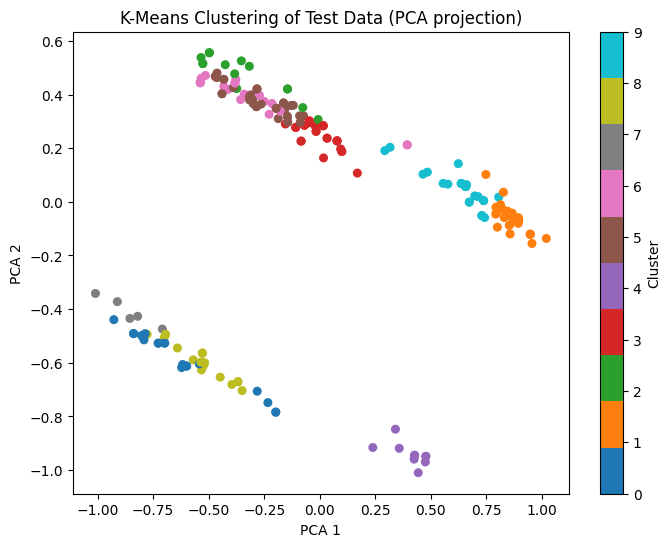

,index,chol,trestbps,thalach,oldpeak,exang,cp
820,820,207,140,138,1.9,1,0
821,821,268,140,160,3.6,0,0
822,822,253,130,144,1.4,1,0
824,824,166,138,125,3.6,1,0
825,825,252,135,172,0.0,0,2
...,...,...,...,...,...,...,...
1015,1015,216,128,131,2.2,1,0
1017,1017,282,123,95,2.0,1,0
1020,1020,221,140,164,0.0,1,1
1021,1021,258,125,141,2.8,1,0


In [26]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans_labels = kmeans.fit_predict(X_test)
test_data['kmeans_cluster'] = kmeans_labels

# Group by K-Means clusters
kmeans_profiles = test_data.groupby('kmeans_cluster')[risk_factors].mean().reset_index()
kmeans_profiles['count'] = test_data.groupby('kmeans_cluster').size().values
kmeans_profiles['risk_score'] = kmeans_profiles.apply(compute_risk_score, axis=1)

# Visualize K-Means clusters using PCA
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=kmeans_labels, cmap='tab10', s=30)
plt.title('K-Means Clustering of Test Data (PCA projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Show top 5 riskiest K-Means clusters
high_risk_kmeans_clusters = kmeans_profiles.sort_values(by='risk_score', ascending=False)
high_risk_kmeans_clusters.head(5)

# Identify patients in top 5 risky K-Means clusters
top_kmeans_clusters = high_risk_kmeans_clusters.head(5)['kmeans_cluster'].tolist()
high_risk_kmeans_patients = test_data[test_data['kmeans_cluster'].isin(top_kmeans_clusters)]
high_risk_kmeans_patients[['index'] + risk_factors]
